In [31]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from statistics import mean
import numpy as np

In [32]:
# 1) Load Breast Cancer Wisconsin (Diagnostic) dataset
data = pd.read_csv('data.csv')
data.head(10)

# Drop redundant ID column
data = data.drop('id', axis=1)

# Features and target (target stays categorical: 'diagnosis' = 'B' or 'M')
X = data.drop('diagnosis', axis=1)
Y = data['diagnosis']

# Sanity check
Y.value_counts()

# Train/test split (same style as your code)
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

In [30]:
# 1) Drop redundant ID column and encode target
data = data.drop(columns=["id"])
label_map = {"B": 0, "M": 1}
data["diagnosis_num"] = data["diagnosis"].map(label_map)

# Features and target (use exact column names)
X = data.drop(columns=["diagnosis", "diagnosis_num"])
Y = data["diagnosis_num"]

# Split with stratification for reproducibility and class balance
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

In [33]:
# 2) Baseline Decision Tree (default = Gini)
from sklearn.tree import DecisionTreeClassifier
dt_clr = DecisionTreeClassifier(random_state=42)
dt_clr.fit(X_train, Y_train)
Y_dt_pred = dt_clr.predict(X_test)
Y_dt_pred

dt_clr_df = pd.DataFrame({'Actual': Y_test, 'Predicted': Y_dt_pred})
dt_clr_df
dt_accuracy = accuracy_score(Y_test, Y_dt_pred)
print(f"Baseline accuracy for Decision Tree (Gini, depth=None): {dt_accuracy:.4f}")

Baseline accuracy for Decision Tree (Gini, depth=None): 0.9474


In [34]:
# 3) Cross-validation over max_depth for both criteria
depths = range(1, 21)

# Gini
scores_gini = []
for d in depths:
    score = cross_val_score(
        DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=42),
        X_train, Y_train, cv=5, scoring='accuracy'
    )
    scores_gini.append(mean(score))

# Entropy
scores_entropy = []
for d in depths:
    score = cross_val_score(
        DecisionTreeClassifier(criterion='entropy', max_depth=d, random_state=42),
        X_train, Y_train, cv=5, scoring='accuracy'
    )
    scores_entropy.append(mean(score))

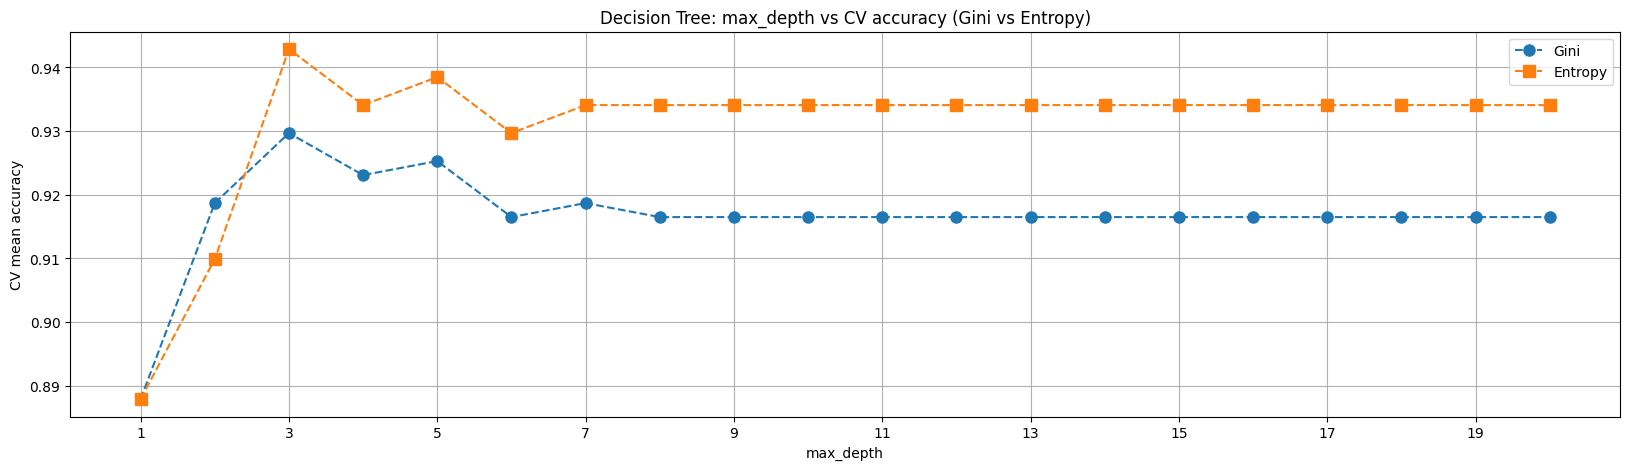

In [35]:
# 4) Plot the curves
plt.figure(figsize=(20, 5))
plt.plot(depths, scores_gini, marker='o', linestyle='dashed', label='Gini', markersize=8)
plt.plot(depths, scores_entropy, marker='s', linestyle='dashed', label='Entropy', markersize=8)
plt.xlabel('max_depth')
plt.ylabel('CV mean accuracy')
plt.title('Decision Tree: max_depth vs CV accuracy (Gini vs Entropy)')
plt.xticks(np.arange(1, 21, step=2))
plt.grid(True)
plt.legend()
plt.show()

In [36]:
# 5) Best depth per criterion
best_depth_gini = depths[int(np.argmax(scores_gini))]
best_cv_gini = max(scores_gini)
best_depth_entropy = depths[int(np.argmax(scores_entropy))]
best_cv_entropy = max(scores_entropy)

print(f"Gini best max_depth: {best_depth_gini} with CV accuracy {best_cv_gini:.4f}")
print(f"Entropy best max_depth: {best_depth_entropy} with CV accuracy {best_cv_entropy:.4f}")

# Choose the overall best
if best_cv_gini >= best_cv_entropy:
    best_criterion = 'gini'
    best_depth = best_depth_gini
    best_cv = best_cv_gini
else:
    best_criterion = 'entropy'
    best_depth = best_depth_entropy
    best_cv = best_cv_entropy

print(f"Selected: criterion={best_criterion}, max_depth={best_depth} (CV={best_cv:.4f})")

Gini best max_depth: 3 with CV accuracy 0.9297
Entropy best max_depth: 3 with CV accuracy 0.9429
Selected: criterion=entropy, max_depth=3 (CV=0.9429)


In [37]:
# 6) Fit the optimized model and evaluate on the test set
dt_clr_opt = DecisionTreeClassifier(criterion=best_criterion, max_depth=best_depth, random_state=42)
dt_clr_opt.fit(X_train, Y_train)
Y_dt_opt_pred = dt_clr_opt.predict(X_test)
print(f"Test accuracy for optimized Decision Tree: {accuracy_score(Y_test, Y_dt_opt_pred):.4f}")

Test accuracy for optimized Decision Tree: 0.9649


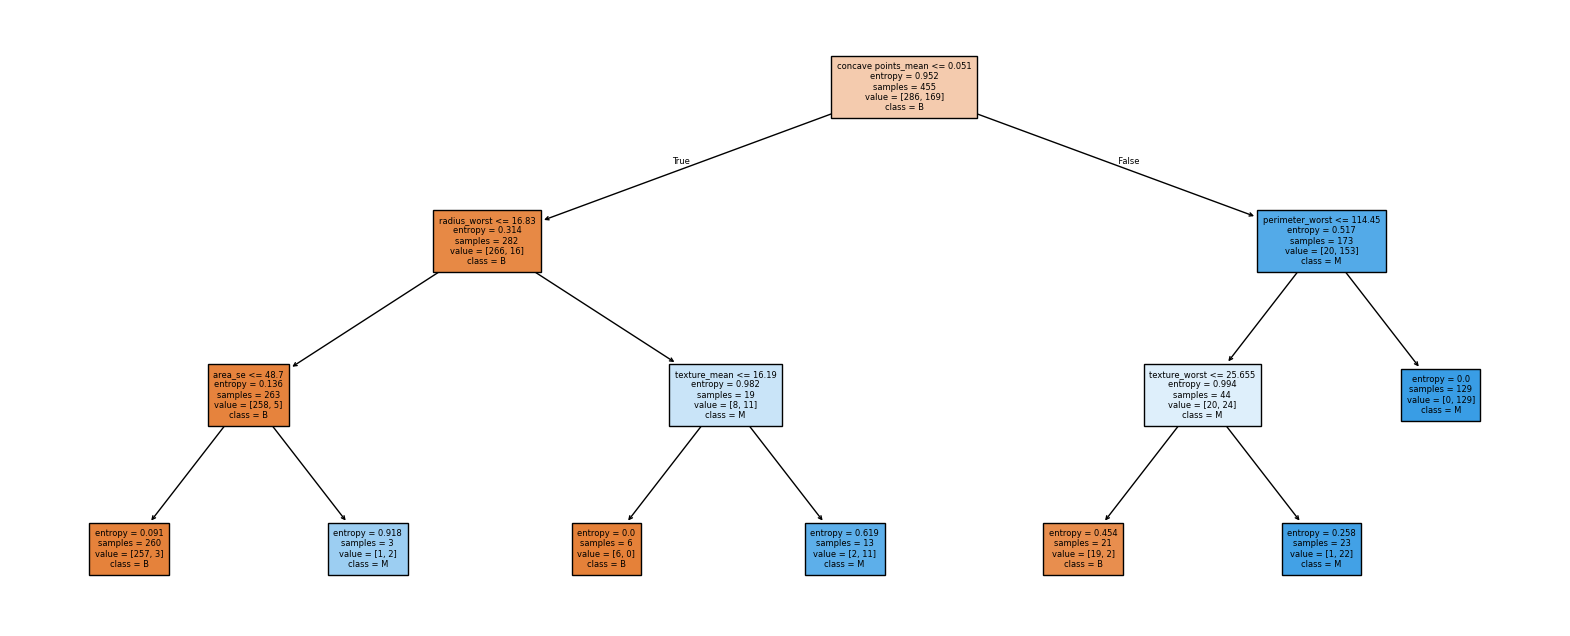

In [38]:
# 7) Plot the optimized tree
from sklearn import tree
plt.figure(figsize=(20, 8))
tree.plot_tree(
    dt_clr_opt,
    fontsize=6,
    feature_names=X.columns,
    class_names=[str(c) for c in dt_clr_opt.classes_],
    filled=True
);